In [1]:
import os
print(os.getcwd())


/


In [3]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=1be70fb76c51bc0f2d18525571d16ff1820f7b1d30988fd5a545fb531eed71b7
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle


In [4]:
!mkdir -p ~/.kaggle
!mv /path/to/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat '/path/to/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
'''
Task 1
Fetch MQTTset from Kaggle
'''
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = 'cnrieiit/mqttset'
api.dataset_download_files(dataset, path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/cnrieiit/mqttset


In [1]:
import pyspark
from pyspark.sql import SparkSession

try:
    spark = SparkSession.getActiveSession()
    if spark is None:
        print("No active SparkSession found.")
    else:
        print("An active SparkSession is running.")
except Exception as e:
    print("Error checking SparkSession:", e)


No active SparkSession found.


In [82]:
print("help")

help


In [2]:
'''
Task 1
Setup SparkSession and test connection to Postgres

Note, you don't need all of those jars if you just ssh into the VM and run this command
to download the cloud_sql_proxy, and point your Spark Database Connection to localhost:5432

wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
chmod +x cloud_sql_proxy
./cloud_sql_proxy -instances=systool-436201:us-east1:projectdb=tcp:5432 &

That instance is specific to my project, but you get the idea
'''
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit 


# Define dataset, spark constants
APPNAME = 'Roberts_Systool_Project'
MASTER = 'yarn'
JDBC_JAR_PATHS = [
    "home/jroberts1187/course-project-option-2-aitechroberts/postgresql-42.7.4.jar",
]

# JDBC_URL = 'jdbc:postgresql://104.196.99.150:5432/projectdb' CloudSQL URL
'''
Point all nodes (master and workers) to local host to run through each of their own CloudSQL Proxies
'''
JDBC_URL = 'jdbc:postgresql://127.0.0.1:5432/postgres'
DB_PROPERTIES = {
    "user": "postgres",
    "password": "postgres_pw",
    "driver": "org.postgresql.Driver",
    "batchsize": "10000" # trying to optimize the write and seems to have cut the time in half
}

# Initialize Spark session with PostgreSQL JDBC driver
spark = SparkSession.builder \
    .appName(APPNAME) \
    .master(MASTER) \
    .config('spark.jars',JDBC_JAR_PATHS[0]) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .getOrCreate()

# Local Spark Configuration
# # Initialize Spark session with PostgreSQL JDBC driver
# spark = SparkSession.builder \
#     .appName(APPNAME) \
#     .master(MASTER)\
#     .config('spark.driver.host','127.0.0.1')\  
#     .config("spark.jars", JDBC_JAR_PATHS[0]) \
#     .config("spark.driver.memory", "4g") \  
#     .config("spark.executor.memory", "3g") \
#     .getOrCreate()

# df = spark.read.jdbc(url=JDBC_URL, table="mqtt", properties=DB_PROPERTIES)
# df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 23:09:28 INFO SparkEnv: Registering MapOutputTracker
24/11/14 23:09:28 INFO SparkEnv: Registering BlockManagerMaster
24/11/14 23:09:28 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/11/14 23:09:28 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
spark.stop()
# SparkContext.stop()

In [3]:
simple_df = spark.range(1000)
simple_df.show(5)


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



In [3]:
JDBC_URL = 'jdbc:postgresql://127.0.0.1:5432/postgres'
# Add the JAR to the current SparkSession
DB_PROPERTIES = {
    "user": "postgres",
    "password": "postgres_pw",
    "driver": "org.postgresql.Driver",
    "connectTimeout": "10",
    "batchsize": "10000" # trying to optimize the write and seems to have cut the time in half in local
}

try:
    df = spark.read.jdbc(url=JDBC_URL, table='test', properties=DB_PROPERTIES)
    df.show()  # This should display a single row with "3" if the connection is successful
    print("Connection to PostgreSQL database successful!")
except Exception as e:
    print("Failed to connect to PostgreSQL database:", e)

+---+
|val|
+---+
|  3|
+---+

Connection to PostgreSQL database successful!


In [18]:
'''
Task 1
Ingest data with Spark and write to Postgres

Creates a dictionary for data files and associated data category,
then loops over both values using .items() method

In the loop, it dynamically changes the data category and write mode
based on where the code executes in the loop. First loop overwrites
to create table and schema if not already exists. Second loop appends

Trying optimizations for fun, repartitioning with the rule of thumb of
2x the number of cores and using 3 of the 4 cores while leaving 1 for
other processes increased speed by about 55-60% from 12mins to about
5.75mins. Including batchsize of 10,000 also just about cut the time
in half from there down to right at 2 minutes and 45 seconds.
'''
import os


COL_NAMES = [
    'tcp_flags', 'tcp_time_delta', 'tcp_len', 'mqtt_conack_flags', 
    'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conack_val', 
    'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 
    'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_uname', 
    'mqtt_conflag_willflag', 'mqtt_conflags', 'mqtt_dupflag', 'mqtt_hdrflags', 
    'mqtt_kalive', 'mqtt_len', 'mqtt_msg', 'mqtt_msgid', 'mqtt_msgtype', 
    'mqtt_proto_len', 'mqtt_protoname', 'mqtt_qos', 'mqtt_retain', 
    'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_ver', 'mqtt_willmsg', 
    'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'target'
]

# LOCAL_DATA_FOLDER = "./Data/FINAL_CSV" # won't change due to mqttset zip
HDFS_DATA_FOLDER = "hdfs://cluster-893d-m/user/hadoop/Data/FINAL_CSV"

data_files = {
    'train70_augmented.csv': 'train',
    'test30_augmented.csv': 'test'
}
overwrite = True
for file, set_type_value in data_files.items():
    # Use the 'file://' prefix to ensure Spark reads from the local file system rather than searching HDFS because I didn't put the data there.
    file_path = os.path.join(HDFS_DATA_FOLDER, file)
    
    # Read CSV file
    df = spark.read.csv(file_path, header=False, inferSchema=True).toDF(*COL_NAMES)
    
    # Read the CSV with header
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Rename columns to match COL_NAMES
    for old_name, new_name in zip(df.columns, COL_NAMES):
        df = df.withColumnRenamed(old_name, new_name)
        
    # Add 'set_type' column and dataset value of 'train' or 'test' based on place in dictionary loop
    df = df.withColumn('set_type', lit(set_type_value))
    
    df.repartition(16)
    # Show first row for verification
    # df.show(1)
    
    # Overwrite on the first loop and append on the rest
    write_mode = 'overwrite' if overwrite else 'append'
    
    # Write data to Postgres
    df.write.jdbc(url=JDBC_URL, 
                  table="mqtt", 
                  mode=write_mode, 
                  properties=DB_PROPERTIES,
                  )
    
    # Set overwrite to False after the first write
    if overwrite:
        overwrite = False

In [ ]:
spark.stop()

In [4]:
'''
Task 2
Ingest Data from Postgres into Spark for Data Analysis
'''
num_partitions = 16 # Adjust based on your environment which is 8 cores on Dataproc currently
mqtt_df = spark.read.jdbc(url=JDBC_URL,
                          table="mqtt",
                          properties=DB_PROPERTIES,
                          numPartitions=num_partitions,
                          )


In [5]:
# Number of rows
num_rows = mqtt_df.count()

# Number of columns
num_cols = len(mqtt_df.columns)

print(f"Shape: {num_rows}, {num_cols}")

Shape: 20000000, 35


In [9]:
mqtt_df.printSchema()

# print target col values
# mqtt_df.select("target").distinct().show(truncate=False)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-

In [104]:
'''
Task 2 
1. Find the average length of an MQTT message captured in
the training dataset for a given target X?

Also trying to use best practices in defining functions for employers
Most analytics will be on the test set when possible to limit processing
when possible and should be large enough, but data engineering will require the whole dataset
'''
from pyspark.sql.functions import col, avg, length


def get_average_len(df, type_set='train', target=None):
    '''
    Function filters the dataset as much as possible using input parameters
    then aggregates the average mqtt message length and returns that integer value

    :param set: 'train' or 'test' in mqtt_df
    :param target: 'slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'
    
    return: int
    '''
    if type_set not in ('test', 'train'):
        raise ValueError("set parameter must be 'train' or 'test'")
    elif target not in ('slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'):
        raise ValueError("target parameter must be one of these: 'slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'")
    
    '''
    I think it would be get to .cache() and unpersist(), but I'm afraid I'll break local memory
    so I'll also filter and select to make dataframe as small as possible beforehand
    '''
    len_df = df.filter((col('set_type') == type_set) & (col('target') == target)).select('mqtt_msg').cache()
    
    # get the right column, then len of values in column, then average, all in an aggregate Spark action method, and .agg() requires .alias()
    avg_len = len_df.agg(avg(length(col('mqtt_msg'))).alias('average_length')).collect()
    len_df.unpersist()
    return avg_len[0]['average_length']

print(f"Average MQTT message length is: {get_average_len(mqtt_df, target='dos'):.2f}")

Average MQTT message length is: 83.76


In [117]:
'''
Task 2 
2. For each target value, 
1) what is the average length of TCP messages and 
2) what is the most popular header flags’ code (mqtt.hdrflags)?

Given the task, it seems no other parameters are necessary
'''
from pyspark.sql.functions import col, avg, length


def get_all_avg_tcp_len(df):
    '''
    Function loops over each unique value in the target column
    to add the average tcp message length to a dictionary and
    returns a dictionary with the avg tcp message length for
    each target value and that target's most popular hdrflag
    placed in a dictionary of tuples where [0]=tcp_len and
    [1]=popular_header 

    Example: {'target':(50, 'hdrflag_val')}

    return: dict
    '''
    answer = {}
    targets = [row[0] for row in mqtt_df.select('target').distinct().collect()]
    targets = targets[1:]
    # filters for tcp messages and pulls only necessary columns
    tcp_df = df.filter((col('tcp_len') != 0)  & (col('mqtt_hdrflags').isNotNull())).select('target', 'tcp_len', 'mqtt_hdrflags').cache()
    
    print(targets)
    # Loop over every unique value in target column to get avg tcp_len and top mqtt_hdrflag value
    for target in targets:
        print(target)
        # Filter by target, then get average length
        target_df = tcp_df.filter(col('target') == target).cache()
                         
        tcp_len = target_df.agg(avg(length(col('tcp_len'))).alias('average_length')).collect()
        pop_hdr = target_df.groupBy('mqtt_hdrflags').count().orderBy(col('count').desc()).first()
        
#         # If no mqtt_hdrflags were found, set a default value for pop_hdr
#         if pop_hdr:
#             hdrflag_val = pop_hdr['mqtt_hdrflags']
#         else:
#             hdrflag_val = "No hdrflags found"
        
        answer[target] = (tcp_len[0]['average_length'], pop_hdr['mqtt_hdrflags'])
        print("running through function")
        print(pop_hdr['mqtt_hdrflags'])
        print(tcp_len[0]['average_length'])
        target_df.unpersist()
    # get the right column, then len of values in column, then average, all in an aggregate Spark action method, and .agg() requires .alias()
    tcp_df.unpersist()
    return answer

ans = get_all_avg_tcp_len(mqtt_df)
keys = ans.keys()
for key in keys:
    print(f"Average TCP message length for target value {key} is: {ans[key][0]:.2f} \n and the most popular header value for {key} is: {ans[key][1]}")

24/11/11 19:35:09 WARN CacheManager: Asked to cache already cached data.        
24/11/11 19:35:09 WARN CacheManager: Asked to cache already cached data.


['malformed', 'slowite', 'bruteforce', 'legitimate', 'dos', 'flood']
malformed
running through function
0x00000030
1.7946348733233979
slowite


running through function
0
1.335095567303782
bruteforce


running through function
0x00000010
1.5
legitimate


running through function
0x00000030
1.9717988709457337
dos


running through function
0x00000040
2.418047699773572
flood


running through function
0x00000030
4.842741935483871
Average TCP message length for target value malformed is: 1.79 
 and the most popular header value for malformed is: 0x00000030
Average TCP message length for target value slowite is: 1.34 
 and the most popular header value for slowite is: 0
Average TCP message length for target value bruteforce is: 1.50 
 and the most popular header value for bruteforce is: 0x00000010
Average TCP message length for target value legitimate is: 1.97 
 and the most popular header value for legitimate is: 0x00000030
Average TCP message length for target value dos is: 2.42 
 and the most popular header value for dos is: 0x00000040
Average TCP message length for target value flood is: 4.84 
 and the most popular header value for flood is: 0x00000030


In [118]:
'''
Task 2. 
3. What is the most frequent X TCP flags for traffic with TCP time delta that is smaller than or equal to Y.
- [] X represents a positive integer. Handle scenarios where a user may send
negative values to your function.
- [] Y represents a float value between 0.0 and 5.0.
- [] Make sure to handle this scenario as well: if the user requests 5 most frequent TCP flags but there are 3 Flags that share the same count at rank number 5, please include all of them in your output.

Believing that most frequent X means top X(int) TCP Flags and ranks were not asked for, funtion returns a list of flags
'''

def get_most_frequent_flags(df, X: int, Y: float):
    '''
    Function filters for tcp_flags and tcp_time_delta to minimize data
    for processing. Handles errors by raisng ValueErrors and includes rank
    ties as they appear.

    return: list
    '''
    if 0 >= X:
        raise ValueError("X must be a positive integer.")
    if not (5.0 >= Y >= 0.0):
        raise ValueError("Y must be a float between 0.0 and 5.0.")
    
    # Filter by tcp_time_delta less than Y, then count values in tcp_flags and collect rows
    flags_df = df.filter(col('tcp_time_delta') <= Y).select('tcp_flags')
    desc_flags = flags_df.groupBy('tcp_flags').count().orderBy(col('count').desc()).collect()

    top_flags = []
    for i, row in enumerate(desc_flags):
        # Continue until X int is reached or if the previous row count equals the current row counts to add ties
        if X > i or row['count'] == desc_flags[i - 1]['count']:
            top_flags.append(row['tcp_flags'])
    return top_flags

flags = get_most_frequent_flags(mqtt_df, X=4, Y=.003)
print('The most frequent flags for tcp_time_delta < Y are:')
for flag in flags:
    print(f'{flag}') 

The most frequenXt flags for tcp_time_delta < Y are:
0x00000010
0x00000018
0x00000002
0x00000011


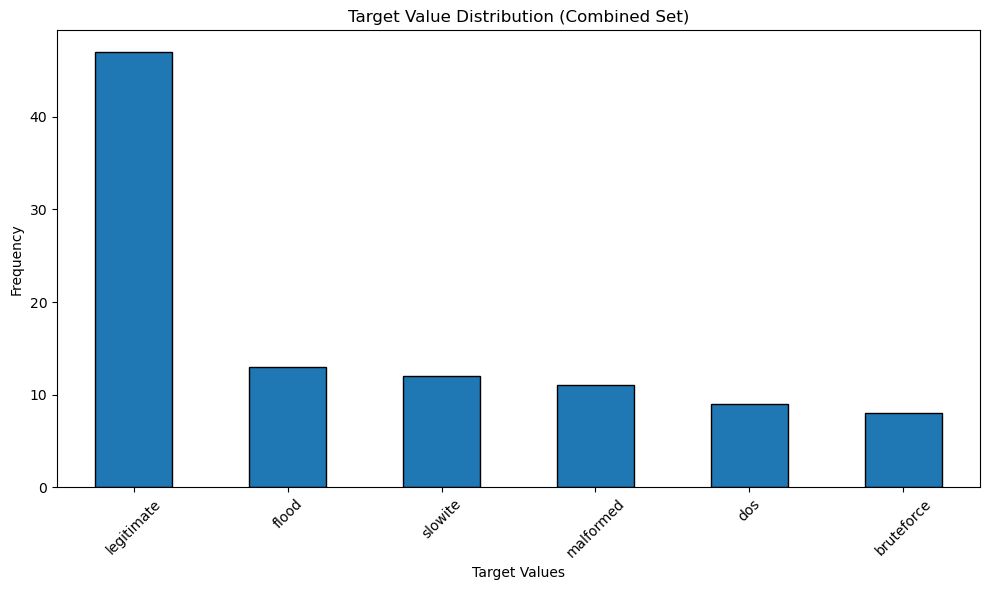

In [10]:
'''
Task 2.
4. Show a histogram for the target values in the training, testing or combined
dataset.
- [] Your code should accept an argument that defines if the histogram is
shown for the training, testing or combined.
'''
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, avg, length


def create_target_hist(df, set_type='test'):
    '''
    Function ensures correct parameters, filters for the target column
    based on the set_type: 'test', 'train' or combined. Puts values
    from target column into list. Then creates a histogram

    return: None
    '''
    if set_type not in ('test', 'train', 'combined'):
        raise ValueError("set parameter must be 'train', 'test' or 'combined'")

    # if set_type != 'combined':
    #     hist_df = df.filter(col('set_type') == set_type).select('target')
    # else:
    #     hist_df = df.select('target')
        
    if set_type != 'combined':
        hist_df = df.filter((col('set_type') == set_type) & (col('target') != 'target')).select('target')
    else:
        hist_df = df.filter(col('target') != 'target').select('target')

    # test_df = spark.createDataFrame([("example",), ("test",)], ["target"])
    # test_pdf = test_df.toPandas()
    # print(test_pdf)

    # Convert to Pandas DataFrame
    pdf = hist_df.limit(100).toPandas()
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    pdf['target'].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Target Value Distribution ({set_type.capitalize()} Set)')
    plt.xlabel('Target Values')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

# create_target_hist(mqtt_df)
# create_target_hist(mqtt_df, set_type='train')
create_target_hist(mqtt_df, set_type='combined')


In [2]:
spark.stop()

NameError: name 'spark' is not defined

In [22]:
'''
Task 3

After conducting research on the dataset as a popular one for ML learning
I discovered an approach to EDA a bit different than the one we covered
in class which first conducts a unique value count across all of the features.
So here I will start with unique value counts. This has the added benefit of
confirming columns with only 2 values so that we can binary encode these columns
to save memory.

Importantly, here we confirm that there are no nulls in the dataset as expected,
determine if the number of unique values matches what we expect as well, then
groupby the occurrence of the most popular feature in a column vs the total count
to see how much of the column actually contains useful information.

The following columns all should have a lot of unique values as the individual message,
message length, the timing of those messages, the unique ids, and the actual message
so I will exclude them from this step
mqtt_msg, mqtt_len, tcp_len, tcp_time_delta, mqtt_msgid

Feature Engineering: Exploratory Data Analysis
'''
import pandas as pd
from pyspark.sql.functions import col, avg, length


def conduct_eda(df, features=[]):
    if not features:
        features = df.columns
    
    # Observations count
    obs_count = df.count()
    
    exempt_features = ['mqtt_len','tcp_len','tcp_time_delta','mqtt_msgid','mqtt_msg']
    # For each column, collect data structure information
    structure_data = []

    for feature in features:
        if feature not in exempt_features:
            
            feature_info = {}

            # Observations and Missing Values
            feature_info['Feature'] = feature
            feature_info['Observations'] = obs_count

            # Unique Values
            feature_info['Unique Values'] = df.select(feature).distinct().count()

            # Variable Type
            feature_info['Variable Type'] = dict(df.dtypes).get(feature)

            # First Value Density
            first_val = df.groupBy(feature).count().orderBy(col("count").desc()).first()
            first_density = (first_val["count"] / obs_count) * 100 if first_val else 0
            feature_info['1st Value Density (%)'] = first_density

            # Feature Type based on unique count
            if feature_info['Unique Values'] == 1:
                feature_info['Feature Type'] = "Superfluous"
            elif feature_info['Unique Values'] == 2:
                feature_info['Feature Type'] = "Flag"
            elif feature_info['Unique Values'] <= 10:
                feature_info['Feature Type'] = "Categorical"
            else:
                feature_info['Feature Type'] = "Categorical - High Cardinality"

            structure_data.append(feature_info)
        else:
            pass
    
    return structure_data

eda_data = conduct_eda(mqtt_df)

print(eda_data)


[{'Feature': 'tcp_flags', 'Observations': 20000000, 'Unique Values': 8, 'Variable Type': 'string', '1st Value Density (%)': 49.528214999999996, 'Feature Type': 'Categorical'}, {'Feature': 'mqtt_conack_flags', 'Observations': 20000000, 'Unique Values': 2, 'Variable Type': 'string', '1st Value Density (%)': 97.21346, 'Feature Type': 'Flag'}, {'Feature': 'mqtt_conack_flags_reserved', 'Observations': 20000000, 'Unique Values': 1, 'Variable Type': 'double', '1st Value Density (%)': 100.0, 'Feature Type': 'Superfluous'}, {'Feature': 'mqtt_conack_flags_sp', 'Observations': 20000000, 'Unique Values': 1, 'Variable Type': 'double', '1st Value Density (%)': 100.0, 'Feature Type': 'Superfluous'}, {'Feature': 'mqtt_conack_val', 'Observations': 20000000, 'Unique Values': 2, 'Variable Type': 'double', '1st Value Density (%)': 99.00571000000001, 'Feature Type': 'Flag'}, {'Feature': 'mqtt_conflag_cleansess', 'Observations': 20000000, 'Unique Values': 2, 'Variable Type': 'double', '1st Value Density (%)

In [23]:
# eda_data = conduct_eda(mqtt_df)

# Assuming eda_list is your list of dictionaries
eda_df = pd.DataFrame(eda_data)

# Print the DataFrame with formatted display options
print(eda_df.to_string(index=False))

                   Feature  Observations  Unique Values Variable Type  1st Value Density (%)                   Feature Type
                 tcp_flags      20000000              8        string              49.528215                    Categorical
         mqtt_conack_flags      20000000              2        string              97.213460                           Flag
mqtt_conack_flags_reserved      20000000              1        double             100.000000                    Superfluous
      mqtt_conack_flags_sp      20000000              1        double             100.000000                    Superfluous
           mqtt_conack_val      20000000              2        double              99.005710                           Flag
    mqtt_conflag_cleansess      20000000              2        double              97.209710                           Flag
       mqtt_conflag_passwd      20000000              2        double              99.011430                           Flag
        

In [25]:
'''
Using the above information we can see that there are some columns where the most popular value
occurs 100% of the time despite the dataset containing nearly 40% of attacks so this value
will not be useful, those columns are all of the 'will message' (which simply tells
the broker what to publish if the client unexpectedly disconnects), the 'reserved' which should
always be 0 and as you can see contain no useful information, the conflag retain and willflag
columns which only contain information on what to retain or do with the willflag so also
worthless, the mqtt quality of service columns except for mqtt_qos, and the mqtt_conack_flags_sp
column, and finally, I'm also dropping the mqtt_msgid column as it's simply an ID and will contain
no useful information.

    'mqtt_willmsg',
    'mqtt_willmsg_len',
    'mqtt_willtopic',
    'mqtt_willtopic_len',
    'mqtt_conack_flags_reserved',
    'mqtt_conflag_reserved',
    'mqtt_conflag_retained',
    'mqtt_conflag_willflag',
    'mqtt_conflag_qos',
    'mqtt_sub_qos',
    'mqtt_suback_qos',
    'mqtt_conack_flags_sp',
    'mqtt_msgid'

After that, we examine the columns which all have the most popular value
as 97.2097% of the data because it's likely that those columns all capture
the same information, and we could only keep one to reduce correlation and
computational expense. Likely keeping mqtt_kalive **already out of columns_to_drop**

'mqtt_ver',
'mqtt_protoname',
'mqtt_proto_len',
'mqtt_kalive',
'mqtt_conflags',
'mqtt_conflag_cleansess',
'mqtt_conack_flags'
'''

maybes = [
    'mqtt_ver',
    'mqtt_protoname',
    'mqtt_proto_len',
    'mqtt_kalive',
    'mqtt_conflags',
    'mqtt_conflag_cleansess',
    'mqtt_conack_flags'
    ]

for maybe in maybes:
    maybe_df = mqtt_df.select(maybe).distinct()
    mabye_df.show()

'''
Following that my assumption based on the data descriptions is that the data
captured in the mqtt_hdrflags column is a collection of multiple other flag
columns mqtt_retain, mqtt_dupflag, mqtt_qos so we'll see
'''

flags = [
    'mqtt_hdrflags',
    'mqtt_retain',
    'mqtt_dupflag',
    'mqtt_qos',
    ]

for flag in flags:
    flag_df = mqtt_df.select(feature).distinct()
    flag_df.show()




+--------------+
|mqtt_protoname|
+--------------+
|             0|
|          MQTT|
+--------------+



+--------+
|mqtt_ver|
+--------+
|     4.0|
|     0.0|
+--------+



+--------------+
|mqtt_protoname|
+--------------+
|             0|
|          MQTT|
+--------------+



+--------------+
|mqtt_proto_len|
+--------------+
|           4.0|
|           0.0|
+--------------+



+-----------+
|mqtt_kalive|
+-----------+
|        1.0|
|      234.0|
|       60.0|
|    65535.0|
|        2.0|
|        0.0|
|        3.0|
+-----------+



+-------------+
|mqtt_conflags|
+-------------+
|   0x00000002|
|            0|
|   0x000000c2|
|   0x00000082|
+-------------+



+----------------------+
|mqtt_conflag_cleansess|
+----------------------+
|                   1.0|
|                   0.0|
+----------------------+



+-----------------+
|mqtt_conack_flags|
+-----------------+
|                0|
|       0x00000000|
+-----------------+



+-------------+
|mqtt_hdrflags|
+-------------+
|   0x00000090|
|   0x00000040|
|   0x00000031|
|            0|
|   0x000000d0|
|   0x00000010|
|   0x00000030|
|   0x000000e0|
|   0x00000020|
|   0x00000032|
|   0x000000c0|
|   0x00000082|
|   0x0000003a|
|   0x00000050|
+-------------+



+-----------+
|mqtt_retain|
+-----------+
|        1.0|
|        0.0|
+-----------+



+------------+
|mqtt_dupflag|
+------------+
|         1.0|
|         0.0|
+------------+



+--------+
|mqtt_qos|
+--------+
|     1.0|
|     0.0|
+--------+



In [ ]:
cols_to_drop = [
    'mqtt_willmsg',
    'mqtt_willmsg_len',
    'mqtt_willtopic',
    'mqtt_willtopic_len',
    'mqtt_conack_flags_reserved',
    'mqtt_conflag_reserved',
    'mqtt_conflag_retain',
    'mqtt_conflag_willflag',
    'mqtt_conflag_qos',
    'mqtt_sub_qos',
    'mqtt_suback_qos',
    'mqtt_conack_flags_sp',
    'mqtt_msgid',
    'mqtt_ver',
    'mqtt_protoname',
    'mqtt_proto_len',
    'mqtt_conflags',
    'mqtt_conflag_cleansess',
    'mqtt_conack_flags',
    'mqtt_dupflag',
    'mqtt_retain',
    'mqtt_qos',
    'mqtt_msg'
]

cleaned_df = cleaned_df.drop(*cols_to_drop)
cleaned_df.write.jdbc(url=JDBC_URL,
                      table="cleaned",
                      mode='overwrite',
                      properties=DB_PROPERTIES,
                     )

In [4]:
num_partitions = 16 # Adjust based on your environment which is 8 cores on Dataproc currently
cleaned_df = spark.read.jdbc(url=JDBC_URL,
                          table='cleaned',
                          properties=DB_PROPERTIES,
                          numPartitions=num_partitions,
                          )

In [5]:
# Number of rows
num_clean_rows = cleaned_df.count()

# Number of columns
num_clean_cols = len(cleaned_df.columns)

print(f"Shape: {num_clean_rows}, {num_clean_cols}")

Shape: 20000000, 12


In [9]:
cleaned_df.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msgtype: double (nullable = true)
 |-- target: string (nullable = true)
 |-- set_type: string (nullable = true)



In [14]:
remaining_cols = cleaned_df.columns

no_check_cols = [ 'tcp_len', 'mqtt_len', 'mqtt_hdrflags', 'tcp_time_delta', 'mqtt_kalive', 'target', 'set_type']
non_continuous_cols =  [col[0] for col in cleaned_df.dtypes if col[0] not in no_check_cols]
for feature in non_continuous_cols:
    feature_df = cleaned_df.select(feature).distinct()
    feature_df.show()

+----------+
| tcp_flags|
+----------+
|0x00000018|
|0x00000019|
|0x00000002|
|0x00000014|
|0x00000010|
|0x00000012|
|0x00000011|
|0x00000004|
+----------+



+---------------+
|mqtt_conack_val|
+---------------+
|            5.0|
|            0.0|
+---------------+



+-------------------+
|mqtt_conflag_passwd|
+-------------------+
|                1.0|
|                0.0|
+-------------------+



+------------------+
|mqtt_conflag_uname|
+------------------+
|               1.0|
|               0.0|
+------------------+



+------------+
|mqtt_msgtype|
+------------+
|         1.0|
|        13.0|
|         5.0|
|         2.0|
|         4.0|
|        14.0|
|         8.0|
|         0.0|
|         3.0|
|         9.0|
|        12.0|
+------------+



In [6]:
'''
Finalize the binary categorical, and numerical columns for analysis and
future encoding.

Having produced the values above, I am casting the following columns to
integer to save memory space going from double to int because the first 3
are binary while the mqtt_len column should be an integer anyway:
'mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_conack_val', 'mqtt_len'

I am casting the following columns from double to string as they are
meant to be categorical rather than numerical:
'mqtt_kalive', 'mqtt_msg_type'
'''
from pyspark.sql.functions import col, avg, length


# Define columns to cast to integer and string
int_cols = ['mqtt_conack_val', 'mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_len']
str_cols = ['mqtt_kalive', 'mqtt_msgtype']

# Cast integer columns
for column in int_cols:
    cleaned_df = cleaned_df.withColumn(column, col(column).cast('integer'))

# Cast string columns
for column in str_cols:
    cleaned_df = cleaned_df.withColumn(column, col(column).cast('string'))

# Verify the schema to ensure changes are applied
cleaned_df.printSchema()
# print(cleaned_df.dtypes)
binary_cols = ['mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_conack_val',]
nominal_cols = [ 'mqtt_msgtype', 'tcp_flags', 'mqtt_hdrflags', 'mqtt_kalive',]
labels = 'target'
train_test = 'set_type'
continuous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_len']

print(continous_cols)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_val: integer (nullable = true)
 |-- mqtt_conflag_passwd: integer (nullable = true)
 |-- mqtt_conflag_uname: integer (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: string (nullable = true)
 |-- mqtt_len: integer (nullable = true)
 |-- mqtt_msgtype: string (nullable = true)
 |-- target: string (nullable = true)
 |-- set_type: string (nullable = true)

['tcp_time_delta', 'tcp_len', 'mqtt_len']


In [19]:
'''
Task 3

It's important to note here that we shouldn't actually have to
calculate and consider outliers as here, we are not trying to
predict a specific numerical outcome based on weights like we did
in the plays.csv in HW4 where a larger numeric column could have
an outsized weight effect on a given prediction if an outlier were
to be input. Here, we actually want outliers because the goal
is to train a classifier to identify anomalies to normal behavior
and it is far more likely that the outliers relate to attacks in
this dataset than negatively affect the prediction accuracy.

So instead, we'll keep all data and move to correlation analysis,
and here I use a heatmap rather than a pairplot, as the correlation
calculation is already computationally expensive, and a pairplot
would make it even more so. Additionally, even with only a 5%
sample of the data and an 8 core 32GB single node, Spark kept
crashing from the attempted collection of partitions to pandas, so
I'm using Spark's Correlation method with Vector Assembler which
should also serve to also go ahead and vectorize the numerical data.


Feature Engineering: Correlation Analysis
'''

# Calculate pairwise correlation matrix
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np

# Assemble numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_vector = assembler.transform(cleaned_df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()
print("Correlation matrix:\n", correlation_matrix)


Correlation matrix:
 [[ 1.          0.0420559  -0.01527093]
 [ 0.0420559   1.          0.03922767]
 [-0.01527093  0.03922767  1.        ]]


In [7]:
'''
Feature Engineering: Handle Categorical Variables with Pipeline

StringIndex and then OneHotEncode the columns of string datatype
'''
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# categorical_cols = [ 'mqtt_msgtype', 'tcp_flags', 'mqtt_hdrflags', 'mqtt_kalive', 'mqtt_msg',]

# String 
stage_1 = StringIndexer(inputCol='mqtt_msgtype', outputCol='mqtt_msg_type_index')
stage_2 = StringIndexer(inputCol='tcp_flags', outputCol='tcp_flags_index')
stage_3 = StringIndexer(inputCol='mqtt_hdrflags', outputCol='mqtt_hdflags_index')
stage_4 = StringIndexer(inputCol='mqtt_kalive', outputCol='mqtt_kalive_index')


encoder_stage = OneHotEncoder(inputCols=['mqtt_msg_type_index', 'tcp_flags_index', 'mqtt_hdflags_index', 
                                     'mqtt_kalive_index',], 
                          outputCols=['mqtt_msg_type_encoded', 'tcp_flags_encoded', 'mqtt_hdflags_encoded', 
                                     'mqtt_kalive_encoded',])



pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, encoder_stage])

pipeline_model = pipeline.fit(cleaned_df)
df_encoded = pipeline_model.transform(cleaned_df)


In [13]:
'''
Feature Engineering: Combining features into a Single vector

'''
from pyspark.ml.feature import VectorAssembler, StandardScaler

# List of original string columns and _index columns to drop
columns_to_drop = ['mqtt_msgtype', 'tcp_flags', 'mqtt_hdrflags', 'mqtt_kalive', 'mqtt_msg',
                  'mqtt_msg_type_index', 'tcp_flags_index', 'mqtt_hdflags_index', 'mqtt_kalive_index']

# Define feature list by dropping unnecessary columns and target column PlayResult
features_only_df = df_encoded.drop(*columns_to_drop)
feature_list = features_only_df.columns
features_only_df.dtypes

# Ensure all the columns are included in the list for VectorAssembler (both integer and vector types)
binary_and_numeric_columns = ['mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_conack_val', 'tcp_len', 'mqtt_len', 'tcp_time_delta']

# Create a VectorAssembler for numeric columns
numeric_assembler = VectorAssembler(
    inputCols=binary_and_numeric_columns,
    outputCol="numeric_vector"
)

# Apply the assembler
df_with_numeric_vector = numeric_assembler.transform(features_only_df)

vector_columns = ['mqtt_msg_type_encoded', 'tcp_flags_encoded', 'mqtt_hdflags_encoded', 'mqtt_kalive_encoded']

# Now, create a final VectorAssembler to combine the numeric vector and the already encoded vectors
stage_final_assembler = VectorAssembler(
    inputCols=["numeric_vector"] + vector_columns,  # Combine numeric vector and the encoded vectors
    outputCol="vectorized_features"
)

# Stage where we scale the columns
stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')


['tcp_time_delta', 'tcp_len', 'mqtt_conack_val', 'mqtt_conflag_passwd', 'mqtt_conflag_uname', 'mqtt_len', 'target', 'set_type', 'mqtt_msg_type_encoded', 'tcp_flags_encoded', 'mqtt_hdflags_encoded', 'mqtt_kalive_encoded', 'numeric_vector', 'vectorized_features']


In [10]:
'''
Task 3

Complete Pipeline from feature engineering above into 

SparkML Model 1: MultiClass Logistic Regression
with Hyperparameter tuning to find the best model using the ParamGridBuilder
for the regularization parameter and the number of iterations to learn.

Format taken almost exactly from that executed in HW 5
'''
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import pandas as pd

binary_cols = ['mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_conack_val']
nominal_cols = ['mqtt_msgtype', 'tcp_flags', 'mqtt_hdrflags', 'mqtt_kalive']
continuous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_len']
label_col = 'label'  # Updated to use 'label' after indexing
train_test_col = 'set_type'

class FeatureTypeCaster(Transformer):  # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer):  # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

# Stage where columns are casted as appropriate types
stage_typecaster = FeatureTypeCaster()

# Stage to index the target column
stage_label_indexer = StringIndexer(inputCol='target', outputCol='label')

# Stage where nominal columns are transformed to index columns using StringIndexer
nominal_id_cols = [x + "_index" for x in nominal_cols]
nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)

# Stage where the index columns are further transformed using OneHotEncoder
stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

# Stage where all relevant features are assembled into a vector
feature_cols = continuous_cols + binary_cols + nominal_onehot_cols
stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

# Stage where we scale the columns
stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

# Removing all unnecessary columns, including 'target'
stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + nominal_id_cols +
                                     nominal_onehot_cols + binary_cols + continuous_cols + ['vectorized_features', 'target'])

# Split the data based on the 'set_type' column
train_df = cleaned_df.filter(cleaned_df[train_test_col] == 'train')
test_df = cleaned_df.filter(cleaned_df[train_test_col] == 'test')

# Define parameter grid manually
paramGrid = [
    {"regParam": 0.01, "maxIter": 1},
    {"regParam": 0.1, "maxIter": 5},
    {"regParam": 1.0, "maxIter": 10}
]

# Set up evaluator
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")

# Track best model and accuracy
best_model = None
best_accuracy = 0.0
best_params = {}

# Iterate over the parameter grid
for params in paramGrid:
    # Define logistic regression model with current parameters
    mlr = LogisticRegression(featuresCol="features", labelCol=label_col, family="multinomial",
                             regParam=params["regParam"], maxIter=params["maxIter"])

    # Assemble the Pipeline
    pipeline = Pipeline(stages=[
        stage_typecaster,
        stage_label_indexer,
        stage_nominal_indexer,
        stage_nominal_onehot_encoder,
        stage_vector_assembler,
        stage_scaler,
        stage_column_dropper,
        mlr
    ])

    # Train the model on the training data
    pipeline_model = pipeline.fit(train_df)

    # Evaluate on the test set
    predictions = pipeline_model.transform(test_df)
    accuracy = evaluator.evaluate(predictions)

    print(f"Parameters: regParam={params['regParam']}, maxIter={params['maxIter']}, Accuracy: {accuracy:.4f}")

    # Update best model if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline_model
        best_params = params

print(f"Best Model Parameters: regParam={best_params['regParam']}, maxIter={best_params['maxIter']}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

# Optional: Confusion Matrix for the best model
predictions_pd = best_model.transform(test_df).select(label_col, "prediction").toPandas()
confusion_matrix = pd.crosstab(predictions_pd[label_col], predictions_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion Matrix:\n", confusion_matrix)


Parameters: regParam=0.01, maxIter=1, Accuracy: 0.6674


Parameters: regParam=0.1, maxIter=5, Accuracy: 0.7311


Parameters: regParam=1.0, maxIter=10, Accuracy: 0.5766
Best Model Parameters: regParam=0.1, maxIter=5
Best Test Accuracy: 0.7311


Confusion Matrix:
 Predicted      0.0     1.0     2.0     3.0     4.0     5.0
Actual                                                    
0.0        3000000       0       0       0       0       0
1.0         225759  254753       0       0     172  119316
2.0         169298     127  430275       0      75     225
3.0         357600       0       0  237600    1200    3600
4.0         214260   49500    4440       0  187680  144120
5.0         323175     525       0       0      75  276225


In [ ]:
'''
Label Index to Original Target Mapping:
0.0: legitimate
1.0: bruteforce  42% correct, 38% falsely legitimate (false negative), 20% wrongly labeled
2.0: dos         72% correct, 28% falsely legitimate (false negative), <1% wrongly labeled
3.0: flood       40% correct, 60% falsely legitimate (false negative), <1% wrongly labeled
4.0: malformed   31% correct, 36% falsely legitimate (false negative), 33% wrongly labeled
5.0: slowite     46% correct, 54% falsely legitimate (false negative), <1% wrongly labeled
'''

In [11]:
# After fitting the pipeline
pipeline_model = pipeline.fit(train_df)

# Access the StringIndexerModel for the 'target' column
label_indexer_model = pipeline_model.stages[1]  # Adjust index if necessary

# Retrieve the labels
labels = label_indexer_model.labels

# Create a mapping from index to label
index_to_label = {float(index): label for index, label in enumerate(labels)}

# Display the mapping
print("Label Index to Original Target Mapping:")
for index, label in index_to_label.items():
    print(f"{index}: {label}")

# Now, you can interpret your confusion matrix using this mapping


Label Index to Original Target Mapping:
0.0: legitimate
1.0: bruteforce
2.0: dos
3.0: flood
4.0: malformed
5.0: slowite


In [18]:
'''
Task 3

SparkML Model 2: MultiClass Naive Bayes
with Hyperparameter tuning to find the best model using the smoothing

Format taken almost exactly from above and data engineering nearly already complete
'''
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler

minmax_scaler = MinMaxScaler(inputCol="vectorized_features", outputCol="features")
from pyspark.sql.functions import abs

class FeatureTypeCaster(Transformer):  # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()
    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, abs(col(col_name).cast(DoubleType())))
        return output_df

# Define parameter grid manually for Naive Bayes
paramGrid = [
    {"smoothing": 1.0},
    {"smoothing": 0.5},
    {"smoothing": 0.1}
]

stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
NB_stage_minmax_scaler = MinMaxScaler(inputCol="vectorized_features", outputCol="features")
# Set up evaluator
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")

best_NB_model = None
best_NB_accuracy = 0.0
best_NB_params = {}

# Cache the DataFrames after loading
train_df = cleaned_df.filter(cleaned_df[train_test_col] == 'train').cache()
test_df = cleaned_df.filter(cleaned_df[train_test_col] == 'test').cache()

# Iterate over the parameter grid
for params in paramGrid:
    # Define Naive Bayes model with current parameters
    nb = NaiveBayes(featuresCol="features", labelCol=label_col, modelType="multinomial", smoothing=params["smoothing"])

    # Assemble the Pipeline
    pipeline = Pipeline(stages=[
        stage_typecaster,
        stage_label_indexer,           
        stage_nominal_indexer,
        stage_nominal_onehot_encoder,
        stage_vector_assembler,
        NB_stage_minmax_scaler,
        stage_column_dropper,
        nb
    ])

    # Train the model on the training data
    pipeline_model = pipeline.fit(train_df)

    # Evaluate on the test set
    predictions = pipeline_model.transform(test_df)
    accuracy = evaluator.evaluate(predictions)

    print(f"Parameters: smoothing={params['smoothing']}, Accuracy: {accuracy:.4f}")

    # Update best model if current model is better
    if accuracy > best_NB_accuracy:
        best_NB_accuracy = accuracy
        best_NB_model = pipeline_model
        best_NB_params['smoothing'] = params['smoothing']

train_df.unpersist()
test_df.unpersist()
print(f"Best Model Parameters: smoothing={best_NB_params['smoothing']}")
print(f"Best Test Accuracy: {best_NB_accuracy:.4f}")

# Optional: Confusion Matrix for the best model
predictions_pd = best_NB_model.transform(test_df).select(label_col, "prediction").toPandas()
confusion_matrix = pd.crosstab(predictions_pd[label_col], predictions_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion Matrix:\n", confusion_matrix)

Parameters: smoothing=1.0, Accuracy: 0.7291


Parameters: smoothing=0.5, Accuracy: 0.7291


Parameters: smoothing=0.1, Accuracy: 0.7291
Best Model Parameters: smoothing=1.0
Best Test Accuracy: 0.7291


Confusion Matrix:
 Predicted      0.0     1.0     2.0     3.0     4.0     5.0
Actual                                                    
0.0        3000000       0       0       0       0       0
1.0         225759  254925       0       0       0  119316
2.0         169298     202  430275       0       0     225
3.0         336000    1200       0  259200       0    3600
4.0         214260   83400    2160       0  153840  146340
5.0         323175     525       0       0      75  276225


In [ ]:
'''
Label Index to Original Target Mapping:
0.0: legitimate
1.0: bruteforce  42% correct, 38% falsely legitimate (false negative), 20% wrongly labeled
2.0: dos         72% correct, 28% falsely legitimate (false negative), <1% wrongly labeled
3.0: flood       43% correct, 56% falsely legitimate (false negative), <1% wrongly labeled
4.0: malformed   25% correct, 36% falsely legitimate (false negative), 39% wrongly labeled
5.0: slowite     46% correct, 54% falsely legitimate (false negative), <1% wrongly labeled
'''

In [20]:
!pip install torch torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

In [19]:
'''
Task 3

Torch Model 1: Multinomial Logistic Regression
with Hyperparameter tuning to find the best model using the paramgrid

Data engineering taken from HW 6
'''

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn as nn
import torch.optim as optim

# Convert Spark DataFrames to Pandas DataFrames
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

# Define columns
binary_cols = ['mqtt_conflag_uname', 'mqtt_conflag_passwd', 'mqtt_conack_val']
nominal_cols = ['mqtt_msgtype', 'tcp_flags', 'mqtt_hdrflags', 'mqtt_kalive']
continuous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_len']
label_col = 'target'  # Original target column

# Feature Type Casting
for col in binary_cols + continuous_cols:
    train_pd[col] = pd.to_numeric(train_pd[col])
    test_pd[col] = pd.to_numeric(test_pd[col])

# Encode the Target Variable
label_encoder = LabelEncoder()
train_pd['label'] = label_encoder.fit_transform(train_pd[label_col])
test_pd['label'] = label_encoder.transform(test_pd[label_col])

# Drop original target column
train_pd.drop(columns=[label_col], inplace=True)
test_pd.drop(columns=[label_col], inplace=True)

# Label Encoding and One-Hot Encoding for Nominal Features
for col in nominal_cols:
    le = LabelEncoder()
    train_pd[col + '_index'] = le.fit_transform(train_pd[col])
    test_pd[col + '_index'] = le.transform(test_pd[col])

onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_encoded = onehot_encoder.fit_transform(train_pd[[col + '_index' for col in nominal_cols]])
test_encoded = onehot_encoder.transform(test_pd[[col + '_index' for col in nominal_cols]])

nominal_onehot_cols = onehot_encoder.get_feature_names_out([col + '_index' for col in nominal_cols])
train_onehot_df = pd.DataFrame(train_encoded, columns=nominal_onehot_cols)
test_onehot_df = pd.DataFrame(test_encoded, columns=nominal_onehot_cols)

train_onehot_df.reset_index(drop=True, inplace=True)
test_onehot_df.reset_index(drop=True, inplace=True)

# Assemble Features
train_features = train_pd[continuous_cols + binary_cols].reset_index(drop=True)
test_features = test_pd[continuous_cols + binary_cols].reset_index(drop=True)
train_features = pd.concat([train_features, train_onehot_df], axis=1)
test_features = pd.concat([test_features, test_onehot_df], axis=1)

# Feature Scaling
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Prepare Labels
train_labels = train_pd['label'].values
test_labels = test_pd['label'].values

# Create PyTorch Datasets and DataLoaders
class MQTTDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 256

train_dataset = MQTTDataset(train_features_scaled, train_labels)
test_dataset = MQTTDataset(test_features_scaled, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the Model
input_size = train_features.shape[1]
num_classes = len(label_encoder.classes_)

class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

# Hyperparameter Tuning
param_grid = [
    {'lr': 0.01, 'num_epochs': 1},
    {'lr': 0.1, 'num_epochs': 2},
    {'lr': 1.0, 'num_epochs': 3}
]

best_torch_lr_accuracy = 0.0
best_torch_lr_params = {}
best_torch_lr_model_state = None

for params in param_grid:
    model = MultinomialLogisticRegression(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    num_epochs = params['num_epochs']
    
    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Parameters: lr={params['lr']}, num_epochs={params['num_epochs']}, Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_torch_lr_accuracy = accuracy
        best_torch_lr_params = params
        best_torch_lr_model_state = model.state_dict()

print(f"Best Parameters: lr={best_torch_lr_params['lr']}, num_epochs={best_torch_lr_params['num_epochs']}")
print(f"Best Test Accuracy: {best_torch_lr_accuracy:.4f}")

# Load the best model state
model.load_state_dict(best_torch_lr_model_state)

# Confusion Matrix for the best model
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)


ModuleNotFoundError: No module named 'torch'